In [93]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pyvista as pv

## Superficies

In [84]:
xx = []
yy = []
zz = []

for i in range (1,5):
  x = np.linspace(0, 100, 10)
  xi, yi = np.meshgrid(x, x)
  z = np.full_like(x, i*20)
  zi = xi*0 - z
  xx.append(xi/10)
  yy.append(yi/10)
  zz.append(zi/10)

# save the arrays to a file
np.save("surfaces.npy", [xx, yy, zz])

In [89]:
p = pv.Plotter(window_size=(600, 400), notebook=False)
surfaces = pv.MultiBlock()

for i in range (4):
  surf = pv.StructuredGrid(xx[i-1], yy[i-1], zz[i-1])
  surfaces.append(surf)

p.add_mesh(surfaces, multi_colors=True)

p.show_grid(
    grid=True,
    ticks="outside",
)
p.show();

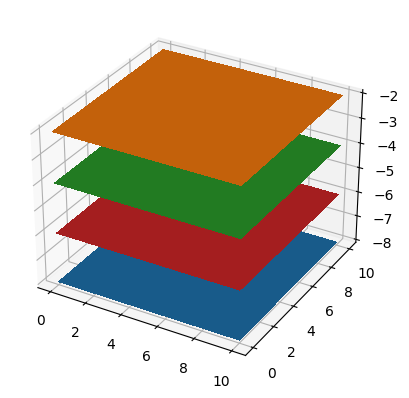

In [85]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

for i in range (4):
  surf = ax.plot_surface(xx[i-1], yy[i-1], zz[i-1], linewidth=0, antialiased=False)

plt.show()

## Capas

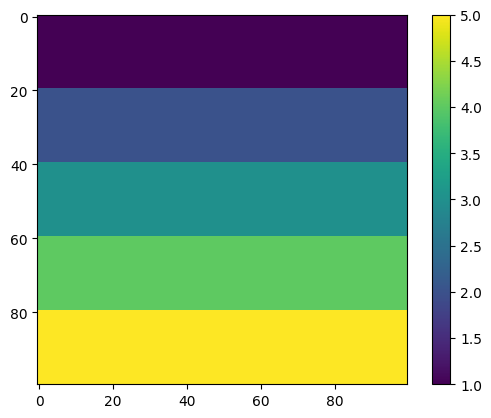

In [68]:
n, m = 100, 100
x_coord, y_coord = np.linspace(0, 100, n), np.linspace(0, 100, m)
xx, yy = np.meshgrid(x_coord, y_coord)
layers = np.zeros((n, m))

vs = [4, 3, 2, 1]

for i in range(1, 5):
    x = np.linspace(0, 100, 100)
    y = np.full_like(x, vs[i-1]*20)
    zz = np.interp(xx, x, y)
    layers = np.where(np.logical_and(yy > zz, layers == 0), i, layers)

layers = np.where(layers == 0, 5, layers)
layers = np.flip(layers, axis=0)
layers = np.tile(layers[np.newaxis,:,:],(100,1,1))
layers = np.transpose(layers, (1,0,2))
np.save('layers.npy', layers)
im = plt.imshow(layers[:,1,:], cmap='viridis')
plt.colorbar(im);

## Velocidades

In [51]:
def asig_vel(modelo: np.ndarray, propiedades: dict) -> np.ndarray:
    """Reemplazo de las IDs del modelo con velocidades
    Parameters
    __________
        modelo : np.ndarray
            Matriz con los IDs de las superficies
        propiedades : dict
            Diccionario con los valores de las propiedades relacionados con los IDs
    Returns
    _______
        modelo_vel : np.ndarray
            Matriz con las velocidades
    """

    # Verificar las entradas
    if not (isinstance(modelo, np.ndarray) and isinstance(propiedades, dict)):
        raise TypeError('Modelo tiene que ser np.array and Propiedades deben ser diccionario')

    shape = modelo.shape
    # Se extraen los valores del diccionario
    k, v = np.array(list(propiedades.keys())), np.array(list(propiedades.values()))

    # Se ordena
    sidx = k.argsort()

    # Se ordenan las propiedades
    k, v = k[sidx], v[sidx]

    # Se crea model_vel
    idx = np.searchsorted(k, modelo.ravel()).reshape(modelo.shape)
    idx[idx == len(k)] = 0
    mask = k[idx] == modelo
    modelo_vel = np.where(mask, v[idx], 0)

    # Reshaping block
    modelo_vel = modelo_vel.reshape(shape)

    return modelo_vel

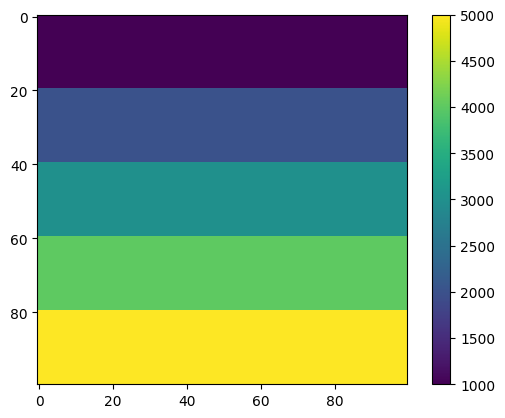

In [107]:
velocity_values = np.round(np.linspace(1000, 5000, 5))
velocity_dict = {k: v for k,v in zip(np.unique(np.round(layers)), velocity_values)}
velocities = asig_vel(layers, velocity_dict)
np.save('velocities.npy', velocities)
im = plt.imshow(velocities[:,:,1], cmap='viridis')
plt.colorbar(im);

In [108]:
from fteikpy import Eikonal3D, grid_to_meshio
from functools import reduce

In [109]:
def ray2line(ray):
    """Convert a ray array to PolyData."""
    nr = len(ray)
    points = np.column_stack((ray[:, 1], ray[:, 2], -ray[:, 0]))
    lines = np.column_stack((np.full(nr - 1, 2), np.arange(nr - 1), np.arange(1, nr)))
    
    return pv.PolyData(points, lines=lines)

In [110]:
vel = velocities.astype(float) 
vel *= 1e-03

In [111]:
src=(0.0, 0.0, 0.0)

In [112]:
rcvs = np.array([[0., float(x), float(y)] for x in range(7, 11) for y in range(7, 11)])

In [113]:
# Se calcula el tiempo de viaje para la fuente
eik = Eikonal3D(grid=vel, gridsize=(0.1, 0.1, 0.1))
tt = eik.solve(sources=src, nsweep=2, return_gradient=True)
rays = tt.raytrace(points=rcvs)

In [114]:
# Se crea la malla para PyVista
mesh = pv.from_meshio(grid_to_meshio(eik, tt))

In [115]:
mesh

UnstructuredGrid (0x20b239e9cc0)
  N Cells:    1000000
  N Points:   1030301
  X Bounds:   0.000e+00, 1.000e+01
  Y Bounds:   0.000e+00, 1.000e+01
  Z Bounds:   -1.000e+01, -0.000e+00
  N Arrays:   3

In [116]:
surfaces

MultiBlock (0x20b1ae09120)
  N Blocks:	4
  X Bounds:	0.000, 10.000
  Y Bounds:	0.000, 10.000
  Z Bounds:	-8.000, -2.000

In [117]:
lines = [ray2line(ray) for ray in rays]
rays = pv.PolyData()
rays = reduce(lambda x, y: x.merge(y), [x for x in lines])

In [120]:
p = pv.Plotter(window_size=(1500, 600), notebook=False)

# Cubo
p.add_mesh(
    mesh,
    scalars="Velocity",
    scalar_bar_args={
        "title": "Velocity [km/s]",
        "height": 0.7,
        "width": 0.05,
        "position_x": 0.92,
        "position_y": 0.15,
        "vertical": True,
        "fmt": "%.1f",
        "title_font_size": 20,
        "label_font_size": 20,
        "font_family": "arial",
    },
    opacity=0.5,
    cmap=mpl.colormaps['plasma'],
)

# Superficies
p.add_mesh(
    surfaces,
    opacity=0.3
)

# Frente de onda
#p.add_mesh(
#    contour,
#    color="blue",
#    line_width=1,
#    opacity=0.1,
#    label='Frente de onda'
#)

# Fuente y receptores
actor = p.add_points(
    rcvs[:, [1, 2, 0]], 
    label='R', 
    color="black", 
    point_size=5.0,
)

# Rayos
p.add_mesh(
    rays,
    color="red",
    line_width=5,
    label='Rayos'
)

# Leyenda
#p.add_legend(
#    loc='upper left',
#    face=None,
#    size=(0.1, 0.1),
#    bcolor=None,
#)

# Ejes
p.show_grid(
    grid=False,
    ticks="outside",
    xlabel="x [km]",
    ylabel="y [km]",
    zlabel="z [km]",
    font_size=20,
    font_family="arial",
)
p.show(
    #cpos=[ # tracker -> positions, focals, ups
    #    (277.45668425388305, -142.55058277045123, 218.55728313335447),
    #    (65.40088110328892, 57.477231885990065, -54.63057096099253),
    #    (-0.44718657732022815, 0.5199247442542968, 0.7278065851424566),
    #]
)